In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import radical.pilot as rp
import radical.utils as ru
import radical.analytics as ra
from radical.entk import Profiler
import numpy as np
from math import sqrt
import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
FONTSIZE = SIZE
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y))
    
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
def get_wf_adap(path):
    p = Profiler(src=path)
    pipe_uid = open(path+'/radical.entk.wfprocessor.0000-proc.prof','r').readlines()[9].split(',')[-3]
#     print pipe_uid
    return p.duration(objects=[pipe_uid], states=['SCHEDULING','DONE'])

In [4]:
def get_wf_predef(path):
    path = glob.glob(path+'/re.session*')[0]
    p = Profiler(src=path)
    return p.duration(objects=['radical.entk.pipeline.0000'], states=['SCHEDULING','DONE'])

In [5]:
stages = [16,32,64]
df = pd.DataFrame(columns=['predef','adap'])
for s in stages:
    predef_path = '../raw_data/app_predef/dur-60-stages-%s'%s
    predef_time = get_wf_predef(predef_path)
    adap_path = '../raw_data/app_adap/trial_1/dur-60-addstages-%s'%s
    adap_time = get_wf_adap(adap_path)
    df.loc[s] = [predef_time, adap_time]

In [6]:
display(df)

,predef,adap
16,1040.0151,1112.1647
32,2089.2016,2155.0919
64,4179.8320,4152.5660


/home/vivek/Research/ves/ve-pandas/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


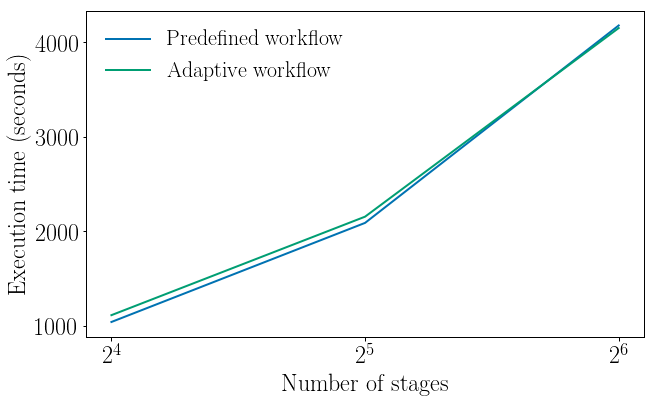

In [7]:
fig, ax = fig_setup(1,1,(10,6))
ax = df.plot(ax=ax[0][0], kind='line', legend=False)
ax.set_xscale('log',basex=2)
ax.set_xlabel('Number of stages')
ax.set_ylabel('Execution time (seconds)')
handles, labels = ax.get_legend_handles_labels()
labels = ['Predefined workflow','Adaptive workflow']
ax.legend(handles, labels)

fig.savefig('../plots/task-count-adaptivity.png', dpi=100)
fig.savefig('../plots/task-count-adaptivity.pdf', dpi=100)

In [8]:
def get_task_uids(path,s):
    
    f = open(path+'/radical.entk.wfprocessor.0000-proc.prof','r').readlines()
    task_uids = []
    for line in f:
        for word in line.split(','):
            if word.startswith('radical.entk.task.') and word not in task_uids:
                task_uids.append(word)   
    return task_uids

In [9]:
def get_adapt_time(path):
    f = f = open(path+'/radical.entk.wfprocessor.0000-obj.prof','r').readlines()
    t_start=0
    t_stop=0
    dur = 0.0
    for line in f:
        words = line.split(',')
        if words[1].startswith('executing post-exec'):
            t_start = float(words[0])
        if words[1].startswith('post-exec executed'):
            t_stop = float(words[0])
        if t_start > 0 and t_stop > 0:
            dur += t_stop - t_start
            t_start=0
            t_stop=0
    return dur

In [10]:
def get_data(df):
    '''
    Columns on the dataframe
    'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
    'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
    'Execution time'
    '''
        
    trials=1
    stages = [16,32,64]

    for s in stages:
        
        entk_setup_ov_list = list()
        entk_teardown_ov_list = list()
        rp_teardown_ov_list = list()
        entk_mgmt_ov_list = list()
        entk_adap_ov_list = list()
        rp_ov_list = list()
        exec_list = list()
        
        for t in range(1,trials+1):
        
            path = '../raw_data/app_adap/trial_1/dur-60-addstages-%s/rp.session.*.json'%s
            json_files = glob.glob(path)        
            json_file = json_files[0]
            json      = ru.read_json(json_file)
            sid       = os.path.basename(json_file)[:-5]

            print sid

            if s==64:
                session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
                session.filter(etype=['unit'])
                unit_uids = sorted(session.list('uid'))
                units = session.filter(uid=unit_uids[:s], etype='unit', inplace=False)
            else:
                session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
                units = session.filter(etype='unit', inplace=False)
            

            p = Profiler(src=os.path.dirname(path))        
            task_uids = get_task_uids(os.path.dirname(path),s)

            entk_dur = p.duration(task_uids, states=['SCHEDULING', 'DONE'])    
            # Time taken in appmanager to rreq function call
            entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
            # Time taken to create resource manager obj
            entk_core_2 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
            # Time taken to tear down appmanager
            entk_teardown_1 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
            # Time taken to deallocate resource reservation
            entk_teardown_2 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
            # Time to adapt
            entk_adapt = get_adapt_time(os.path.dirname(path))
            
            
            rp_dur = units.duration([rp.NEW, rp.DONE])
            exec_dur = units.duration(event=[{ru.EVENT: 'exec_start'},
                                             {ru.EVENT: 'exec_stop'}])
    
            # 'EnTK setup overhead'
            entk_setup_ov = entk_core_1 + entk_core_2
            # EnTK teardown overhead'
            entk_teardown_ov = entk_teardown_1 - entk_teardown_2
            # RP cancelation overhead'
            entk_rp_cancel_ov = entk_teardown_2
            # 'EnTK task management overhead'
            entk_task_mgmt_ov = entk_dur - rp_dur
            # 'RP overhead'
            rp_ov = rp_dur - exec_dur

            entk_setup_ov_list.append(entk_setup_ov)
            entk_teardown_ov_list.append(entk_teardown_ov)
            rp_teardown_ov_list.append(entk_rp_cancel_ov)
            entk_mgmt_ov_list.append(entk_task_mgmt_ov)
            rp_ov_list.append(rp_ov)
            exec_list.append(exec_dur)
            entk_adap_ov_list.append(entk_adapt)
    
        df.loc[s] = [np.mean(entk_setup_ov_list), 
                           np.mean(entk_teardown_ov_list), 
                           np.mean(rp_teardown_ov_list), 
                           np.mean(entk_mgmt_ov_list), 
                           np.mean(entk_adap_ov_list),
                           np.mean(rp_ov_list),
                           np.mean(exec_list)]
    
#         df_err.loc['mdrun'] = [np.std(entk_setup_ov_list)/sqrt(trials), 
#                              np.std(entk_teardown_ov_list)/sqrt(trials), 
#                              np.std(entk_rp_cancel_ov_list)/sqrt(trials),
#                              np.std(entk_task_mgmt_ov_list)/sqrt(trials), 
#                              np.std(rp_ov_list)/sqrt(trials),
#                              np.std(exec_list)/sqrt(trials),
#                              np.std(data_staging_dur_list)/sqrt(trials)]
    
    return df

In [11]:
df = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])
print get_data(df)

rp.session.js-17-212.jetstream-cloud.org.vivek91.017514.0718
rp.session.js-17-212.jetstream-cloud.org.vivek91.017519.0256
rp.session.js-17-212.jetstream-cloud.org.vivek91.017514.1530
    EnTK setup overhead  EnTK tear-down overhead  RTS tear-down overhead  EnTK management overhead  EnTK adaptivity overhead  RTS overhead  Execution time
16               0.1164                  18.6111                 13.5924                  9.864000                  0.009700     72.435500       1029.6655
32               0.1339                  16.8463                 11.3984                 10.954901                  0.022599    144.890699       1998.8568
64               0.6855                  19.6867                 13.4175                  1.932201                  0.044001    273.218699       3876.2687


/home/vivek/Research/ves/ve-pandas/local/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


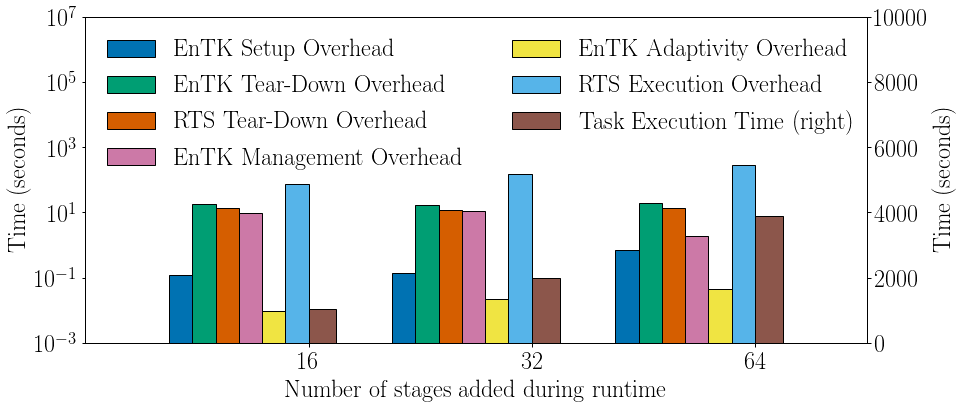

In [12]:
fig, ax = fig_setup(1,1,(14,6))
#print df['EnTK setup overhead'], df['EnTK teardown overhead']

width=0.125
ax = df.plot(kind='bar', 
             ax=ax[0][0],
#              yerr=df_err,
             fontsize=FONTSIZE,
             y = df.columns.drop('Execution time').tolist(),
             width=5*width,
             position=1,
             legend=False,
             logy=True,
             ylim=(0.001,10000000),
            )

ax2 = df['Execution time'].plot(ax=ax, 
                                legend=False,
#                                 yerr = df_err['Execution time'],
                                kind='bar', 
                                secondary_y=True,
                                width=width,
                                rot=0,
                                color=tableau20[10],
                                position=0)

ax.set_xlabel('Number of stages added during runtime', fontsize=FONTSIZE)
ax.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
ax.set_title(ax.get_title(), fontsize=FONTSIZE)
ax2.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
ax2.set_ylim(0,10000)
plt.gca().set_xlim([-1.,2.5])

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = ['EnTK Setup Overhead', 
          'EnTK Tear-Down Overhead', 
          'RTS Tear-Down Overhead',
          'EnTK Management Overhead',
          'EnTK Adaptivity Overhead',
          'RTS Execution Overhead',
          'Task Execution Time (right)']
handles = h1 + h2
plt.legend(handles,labels,fontsize=FONTSIZE, loc='upper left', ncol=2)

fig.savefig('../plots/entk_rp_overheads_stress_supermic.pdf', dpi=100, bbox_inches='tight')
fig.savefig('../plots/entk_rp_overheads_stress_supermic.png', dpi=100, bbox_inches='tight')